##segmentation-models-pytorch

In [1]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 842.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
import os
import cv2
import numpy as np
import random
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
import kagglehub

In [3]:
path = kagglehub.dataset_download("mahmoodyousaf/fish-dataset")
print("Path to dataset files:", path)

root = "/root/.cache/kagglehub/datasets/mahmoodyousaf/fish-dataset/versions/1"

100%|██████████| 342M/342M [00:02<00:00, 130MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mahmoodyousaf/fish-dataset/versions/1


Первоначальное обучение показало себя плохо, так как была проблема с датасетом. Он предназначен для YOLO, и в процессе перевода все маски вышли черными

Masking images: 100%|██████████| 700/700 [00:02<00:00, 308.85it/s]
<ipython-input-14-60afbc726706>:110: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



🔁 Epoch 1/5


Train Loss: 0.1636 | Val Loss: 0.0000
Saved best model.

🔁 Epoch 2/5


Train Loss: 0.1610 | Val Loss: 0.0000

🔁 Epoch 3/5


Train Loss: 0.1655 | Val Loss: 0.0000

🔁 Epoch 4/5


Train Loss: 0.1629 | Val Loss: 0.0000

🔁 Epoch 5/5


Train Loss: 0.1657 | Val Loss: 0.0000


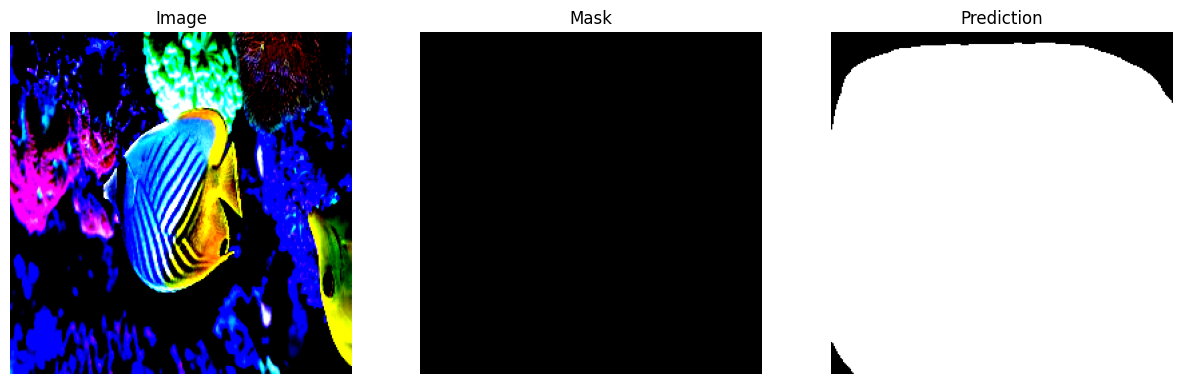

In [14]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import kagglehub

os.environ["TORCHINDUCTOR_MAX_AUTOTUNE_GEMM"] = "0"

root = "/root/.cache/kagglehub/datasets/mahmoodyousaf/fish-dataset/versions/1"

def yolo_to_masks(img_dir, label_dir, mask_dir, class_id_to_draw=0):
    os.makedirs(mask_dir, exist_ok=True)
    image_paths = sorted(glob(os.path.join(img_dir, "*.jpg")))
    for img_path in tqdm(image_paths, desc=f"Masking {os.path.basename(img_dir)}"):
        img = cv2.imread(img_path)
        height, width = img.shape[:2]
        mask = np.zeros((height, width), dtype=np.uint8)
        label_path = os.path.join(label_dir, os.path.splitext(os.path.basename(img_path))[0] + ".txt")
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    if class_id != class_id_to_draw:
                        continue
                    x_center, y_center, w, h = map(float, parts[1:])
                    x_center *= width
                    y_center *= height
                    w *= width
                    h *= height
                    x1 = int(x_center - w / 2)
                    y1 = int(y_center - h / 2)
                    x2 = int(x_center + w / 2)
                    y2 = int(y_center + h / 2)
                    cv2.rectangle(mask, (x1, y1), (x2, y2), color=255, thickness=-1)

        mask_path = os.path.join(mask_dir, os.path.basename(img_path).replace(".jpg", ".png"))
        cv2.imwrite(mask_path, mask)

yolo_to_masks(os.path.join(root, "train/images"), os.path.join(root, "train/labels"), os.path.join(root, "train/masks"))
yolo_to_masks(os.path.join(root, "valid/images"), os.path.join(root, "valid/labels"), os.path.join(root, "valid/masks"))
yolo_to_masks(os.path.join(root, "test/images"), os.path.join(root, "test/labels"), os.path.join(root, "test/masks"))

class SegmentationDataset(Dataset):
    def __init__(self, images, masks, transforms=None):
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype(np.uint8)

        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask  = augmented['mask']

        return image, mask.unsqueeze(0).float()

train_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])
val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

train_images = sorted(glob(os.path.join(root, "train/images/*.jpg")))
train_masks  = sorted(glob(os.path.join(root, "train/masks/*.png")))
val_images   = sorted(glob(os.path.join(root, "valid/images/*.jpg")))
val_masks    = sorted(glob(os.path.join(root, "valid/masks/*.png")))

train_ds = SegmentationDataset(train_images, train_masks, train_transform)
val_ds   = SegmentationDataset(val_images, val_masks, val_transform)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
).to(device)

loss_fn = smp.losses.DiceLoss(mode="binary")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scaler = GradScaler()
best_loss = float("inf")

num_epochs = 5
patience = 5
counter = 0

for epoch in range(num_epochs):
    print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")
    model.train()
    train_loss = 0

    for imgs, masks in tqdm(train_loader, leave=False, desc="Training"):
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            preds = model(imgs)
            preds = torch.sigmoid(preds)
            loss = loss_fn(preds, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            with autocast(device_type='cuda'):
                preds = model(imgs)
                preds = torch.sigmoid(preds)
                loss = loss_fn(preds, masks)
                val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), "best_unet.pth")
        print("Saved best model.")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping.")
            break

def visualize_sample(image_tensor, mask_tensor, pred_mask):
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    mask = mask_tensor.squeeze().cpu().numpy()
    pred = pred_mask.squeeze()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1); plt.imshow(image); plt.title("Image"); plt.axis("off")
    plt.subplot(1, 3, 2); plt.imshow(mask, cmap="gray"); plt.title("Mask"); plt.axis("off")
    plt.subplot(1, 3, 3); plt.imshow(pred, cmap="gray"); plt.title("Prediction"); plt.axis("off")
    plt.show()

model.load_state_dict(torch.load("best_unet.pth"))
model.eval()

with torch.no_grad():
    img, mask = val_ds[0]
    input_tensor = img.unsqueeze(0).to(device)
    with autocast(device_type='cuda'):
        pred = torch.sigmoid(model(input_tensor))[0].cpu().numpy()
        pred_bin = (pred > 0.5).astype(np.uint8)

    visualize_sample(img, mask, pred_bin)

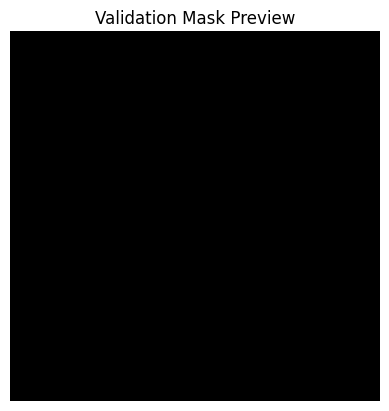

Unique values: [0]


In [15]:
import matplotlib.pyplot as plt
mask = cv2.imread(val_masks[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(mask, cmap='gray')
plt.title("Validation Mask Preview")
plt.axis('off')
plt.show()
print("Unique values:", np.unique(mask))

##segmentation-models-pytorch улучшенный бейзлайн

С улучшенным датасетом улучшился и результат

Generating masks for images: 100%|██████████| 700/700 [00:02<00:00, 262.74it/s]
<ipython-input-16-c5a800d4a6f9>:112: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Epoch 1/5


Train Loss: 0.4978 | Val Loss: 0.5356 | Dice: 0.6993 | IoU: 0.5972

Epoch 2/5


Train Loss: 0.4937 | Val Loss: 0.5392 | Dice: 0.6680 | IoU: 0.5571

Epoch 3/5


Train Loss: 0.4920 | Val Loss: 0.5339 | Dice: 0.7251 | IoU: 0.6285

Epoch 4/5


Train Loss: 0.4901 | Val Loss: 0.5344 | Dice: 0.7098 | IoU: 0.6065

Epoch 5/5


Train Loss: 0.4895 | Val Loss: 0.5331 | Dice: 0.7243 | IoU: 0.6213
Saved final model to best_unet.pth


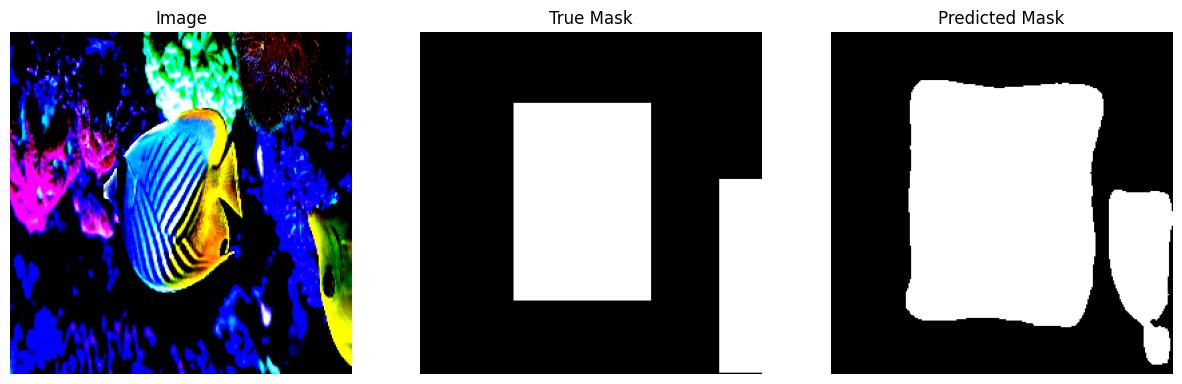

In [16]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast
from torch.cuda.amp import GradScaler

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
import kagglehub

os.environ["TORCHINDUCTOR_MAX_AUTOTUNE_GEMM"] = "0"

root = "/root/.cache/kagglehub/datasets/mahmoodyousaf/fish-dataset/versions/1"

def yolo_to_masks_all_classes(img_dir, label_dir, mask_dir, img_size=(480, 480)):
    os.makedirs(mask_dir, exist_ok=True)
    image_paths = sorted(glob(os.path.join(img_dir, "*.jpg")))

    for img_path in tqdm(image_paths, desc=f"Generating masks for {os.path.basename(img_dir)}"):
        img = cv2.imread(img_path)
        h_img, w_img = img.shape[:2]
        mask = np.zeros((h_img, w_img), dtype=np.uint8)

        label_path = os.path.join(label_dir, os.path.splitext(os.path.basename(img_path))[0] + ".txt")
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue
                    class_id = int(parts[0]) + 1
                    x_center, y_center, w, h = map(float, parts[1:])

                    x_center *= w_img
                    y_center *= h_img
                    w *= w_img
                    h *= h_img

                    x1 = int(x_center - w / 2)
                    y1 = int(y_center - h / 2)
                    x2 = int(x_center + w / 2)
                    y2 = int(y_center + h / 2)

                    cv2.rectangle(mask, (x1, y1), (x2, y2), color=class_id, thickness=-1)

        mask_path = os.path.join(mask_dir, os.path.basename(img_path).replace(".jpg", ".png"))
        cv2.imwrite(mask_path, mask)

yolo_to_masks_all_classes(os.path.join(root, "train/images"), os.path.join(root, "train/labels"), os.path.join(root, "train/masks"))
yolo_to_masks_all_classes(os.path.join(root, "valid/images"), os.path.join(root, "valid/labels"), os.path.join(root, "valid/masks"))
yolo_to_masks_all_classes(os.path.join(root, "test/images"), os.path.join(root, "test/labels"), os.path.join(root, "test/masks"))

class SegmentationDataset(Dataset):
    def __init__(self, images, masks, transforms=None):
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.uint8)

        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0).float()

train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])
val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

train_images = sorted(glob(os.path.join(root, "train/images/*.jpg")))
train_masks  = sorted(glob(os.path.join(root, "train/masks/*.png")))
val_images   = sorted(glob(os.path.join(root, "valid/images/*.jpg")))
val_masks    = sorted(glob(os.path.join(root, "valid/masks/*.png")))

train_ds = SegmentationDataset(train_images, train_masks, train_transform)
val_ds = SegmentationDataset(val_images, val_masks, val_transform)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet("mobilenet_v2", encoder_weights="imagenet", in_channels=3, classes=1).to(device)

loss_fn = smp.losses.DiceLoss(mode="binary")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scaler = GradScaler()

def compute_metrics(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred > threshold).float()
    intersection = (y_pred * y_true).sum()
    union = y_pred.sum() + y_true.sum()
    dice = (2. * intersection) / (union + 1e-6)
    iou = intersection / ((y_pred + y_true - y_pred * y_true).sum() + 1e-6)
    return dice.item(), iou.item()

num_epochs = 5
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()
    train_loss, val_loss = 0, 0
    total_dice, total_iou = 0, 0
    n = 0

    for imgs, masks in tqdm(train_loader, desc="Training", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            preds = torch.sigmoid(model(imgs))
            loss = loss_fn(preds, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc="🔎 Validating", leave=False):
            imgs, masks = imgs.to(device), masks.to(device)
            with autocast(device_type='cuda'):
                preds = torch.sigmoid(model(imgs))
                loss = loss_fn(preds, masks)
                val_loss += loss.item()

                for i in range(len(preds)):
                    dsc, iou = compute_metrics(preds[i], masks[i])
                    total_dice += dsc
                    total_iou += iou
                    n += 1

    print(f"Train Loss: {train_loss/len(train_loader):.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f} | "
          f"Dice: {total_dice/n:.4f} | IoU: {total_iou/n:.4f}")

torch.save(model.state_dict(), "best_unet.pth")
print("Saved final model to best_unet.pth")


def visualize_sample(image_tensor, mask_tensor, pred_mask):
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    mask = mask_tensor.squeeze().cpu().numpy()
    pred = pred_mask.squeeze()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1); plt.imshow(image); plt.title("Image"); plt.axis("off")
    plt.subplot(1, 3, 2); plt.imshow(mask, cmap="gray"); plt.title("True Mask"); plt.axis("off")
    plt.subplot(1, 3, 3); plt.imshow(pred, cmap="gray"); plt.title("Predicted Mask"); plt.axis("off")
    plt.show()

model.load_state_dict(torch.load("best_unet.pth"))
model.eval()

with torch.no_grad():
    img, mask = val_ds[0]
    input_tensor = img.unsqueeze(0).to(device)
    with autocast(device_type='cuda'):
        pred = torch.sigmoid(model(input_tensor))[0].cpu().numpy()
        pred_bin = (pred > 0.5).astype(np.uint8)

    visualize_sample(img, mask, pred_bin)

##Самостоятельная имплементация

Самостоятельно реализованный алгоритм показал себя лучше библиотечного

Generating masks for images: 100%|██████████| 700/700 [00:02<00:00, 273.79it/s]
<ipython-input-18-42b404454c8a>:132: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Epoch 1/5


Train Loss: 0.5236 | Val Loss: 0.7037 | Dice: 0.5179 | IoU: 0.4069

Epoch 2/5


Train Loss: 0.4448 | Val Loss: 0.7049 | Dice: 0.6525 | IoU: 0.5330

Epoch 3/5


Train Loss: 0.4017 | Val Loss: 0.6820 | Dice: 0.6633 | IoU: 0.5507

Epoch 4/5


Train Loss: 0.3739 | Val Loss: 0.6770 | Dice: 0.6940 | IoU: 0.5857

Epoch 5/5


Train Loss: 0.3533 | Val Loss: 0.6704 | Dice: 0.6812 | IoU: 0.5723


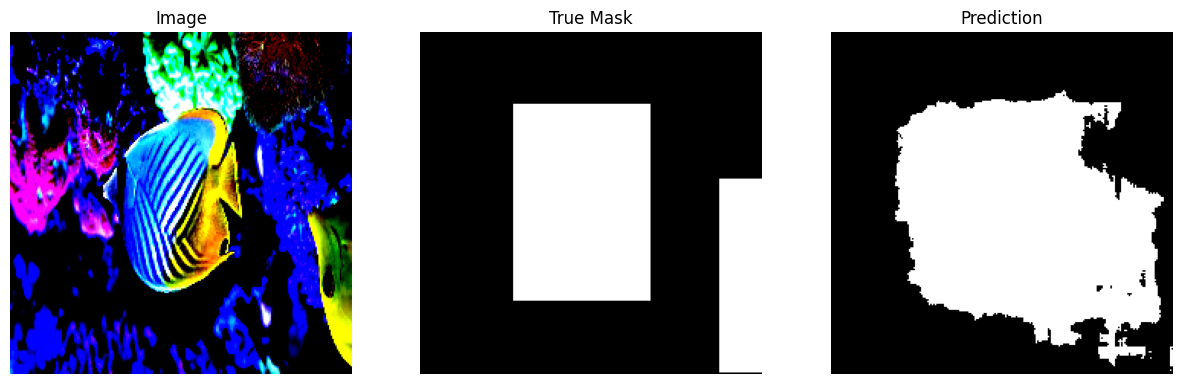

In [18]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast
from torch.cuda.amp import GradScaler

import albumentations as A
from albumentations.pytorch import ToTensorV2
import kagglehub

os.environ["TORCHINDUCTOR_MAX_AUTOTUNE_GEMM"] = "0"

root = "/root/.cache/kagglehub/datasets/mahmoodyousaf/fish-dataset/versions/1"

def yolo_to_masks_all_classes(img_dir, label_dir, mask_dir):
    os.makedirs(mask_dir, exist_ok=True)
    image_paths = sorted(glob(os.path.join(img_dir, "*.jpg")))

    for img_path in tqdm(image_paths, desc=f"Generating masks for {os.path.basename(img_dir)}"):
        img = cv2.imread(img_path)
        h, w = img.shape[:2]
        mask = np.zeros((h, w), dtype=np.uint8)
        label_path = os.path.join(label_dir, os.path.splitext(os.path.basename(img_path))[0] + ".txt")

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5: continue
                    _, x, y, box_w, box_h = map(float, parts)
                    x *= w; y *= h; box_w *= w; box_h *= h
                    x1, y1 = int(x - box_w / 2), int(y - box_h / 2)
                    x2, y2 = int(x + box_w / 2), int(y + box_h / 2)
                    cv2.rectangle(mask, (x1, y1), (x2, y2), color=255, thickness=-1)

        mask_path = os.path.join(mask_dir, os.path.basename(img_path).replace('.jpg', '.png'))
        cv2.imwrite(mask_path, mask)

yolo_to_masks_all_classes(os.path.join(root, "train/images"), os.path.join(root, "train/labels"), os.path.join(root, "train/masks"))
yolo_to_masks_all_classes(os.path.join(root, "valid/images"), os.path.join(root, "valid/labels"), os.path.join(root, "valid/masks"))

class SegmentationDataset(Dataset):
    def __init__(self, images, masks, transforms=None):
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.uint8)

        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0).float()

transform_train = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])
transform_val = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2()
])

train_images = sorted(glob(os.path.join(root, "train/images/*.jpg")))
train_masks  = sorted(glob(os.path.join(root, "train/masks/*.png")))
val_images   = sorted(glob(os.path.join(root, "valid/images/*.jpg")))
val_masks    = sorted(glob(os.path.join(root, "valid/masks/*.png")))

train_ds = SegmentationDataset(train_images, train_masks, transform_train)
val_ds   = SegmentationDataset(val_images, val_masks, transform_val)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=0)

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True)
        )

    def forward(self, x): return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = DoubleConv(3, 32)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)
        self.bottleneck = DoubleConv(128, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv(64, 32)
        self.out = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        b  = self.bottleneck(F.max_pool2d(e3, 2))
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out(d1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scaler = GradScaler()

def compute_metrics(y_pred, y_true, thresh=0.5):
    y_pred = (y_pred > thresh).float()
    intersection = (y_pred * y_true).sum()
    union = (y_pred + y_true).sum()
    dice = (2 * intersection) / (union + 1e-8)
    iou = intersection / ((y_pred + y_true - y_pred * y_true).sum() + 1e-8)
    return dice.item(), iou.item()

for epoch in range(5):
    print(f"\nEpoch {epoch+1}/5")
    model.train()
    train_loss = 0

    for imgs, masks in tqdm(train_loader, desc="Training", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            logits = model(imgs)
            loss = loss_fn(logits, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    model.eval()
    val_loss, total_dice, total_iou, n = 0, 0, 0, 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            with autocast(device_type='cuda'):
                preds = torch.sigmoid(model(imgs))
                loss = loss_fn(preds, masks)
            val_loss += loss.item()
            for i in range(len(preds)):
                d, iou = compute_metrics(preds[i], masks[i])
                total_dice += d
                total_iou += iou
                n += 1

    print(f"Train Loss: {train_loss/len(train_loader):.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f} | "
          f"Dice: {total_dice/n:.4f} | IoU: {total_iou/n:.4f}")

def visualize(image_tensor, mask_tensor, pred_mask):
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    mask = mask_tensor.squeeze().cpu().numpy()
    pred = pred_mask.squeeze()
    plt.figure(figsize=(15, 5))
    for i, (title, data) in enumerate(zip(["Image", "True Mask", "Prediction"], [img, mask, pred])):
        plt.subplot(1, 3, i+1)
        plt.imshow(data if i == 0 else data, cmap='gray')
        plt.title(title)
        plt.axis("off")
    plt.show()

model.eval()
with torch.no_grad():
    img, mask = val_ds[0]
    pred = torch.sigmoid(model(img.unsqueeze(0).to(device))).cpu().numpy()[0]
    visualize(img, mask, (pred > 0.5).astype(np.uint8))

##Имплементация улучшенный бейзлайн

Результат хуже, чем у прошлой реализации, но он заметно улучшался с эпохами. Если бы не ограниченные ресурсы, результат мог бы быть лучше первого варианта.

Generating masks for images: 100%|██████████| 700/700 [00:02<00:00, 314.39it/s]
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-19-62dd3b53ec30>:155: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Epoch 1/5


Train Loss: 1.0384 | Val Loss: 0.9661 | Dice: 0.5624 | IoU: 0.4310
Best model saved.

Epoch 2/5


Train Loss: 0.9581 | Val Loss: 0.9328 | Dice: 0.5532 | IoU: 0.4242

Epoch 3/5


Train Loss: 0.9078 | Val Loss: 0.8467 | Dice: 0.6305 | IoU: 0.5067
Best model saved.

Epoch 4/5


Train Loss: 0.8696 | Val Loss: 0.8097 | Dice: 0.6522 | IoU: 0.5328
Best model saved.

Epoch 5/5


Train Loss: 0.8202 | Val Loss: 0.7150 | Dice: 0.6845 | IoU: 0.5659
Best model saved.


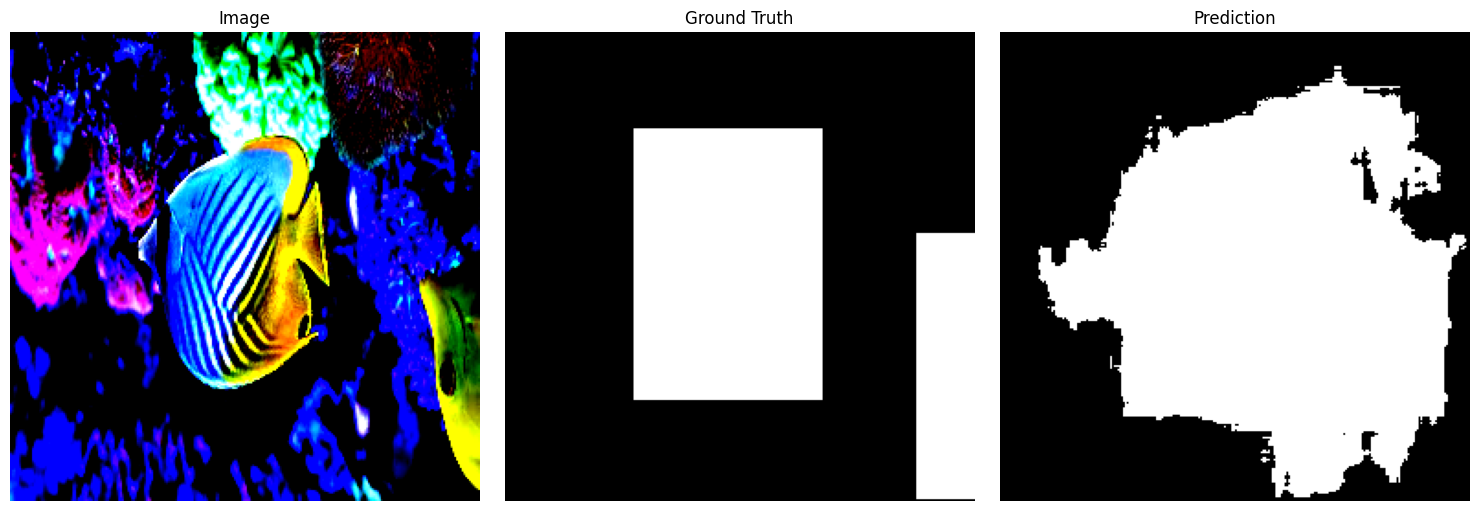

In [19]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast
from torch.cuda.amp import GradScaler

import albumentations as A
from albumentations.pytorch import ToTensorV2
import kagglehub

os.environ["TORCHINDUCTOR_MAX_AUTOTUNE_GEMM"] = "0"

root = "/root/.cache/kagglehub/datasets/mahmoodyousaf/fish-dataset/versions/1"

def yolo_to_masks(img_dir, label_dir, mask_dir):
    os.makedirs(mask_dir, exist_ok=True)
    image_paths = sorted(glob(os.path.join(img_dir, "*.jpg")))

    for img_path in tqdm(image_paths, desc=f"Generating masks for {os.path.basename(img_dir)}"):
        img = cv2.imread(img_path)
        h, w = img.shape[:2]
        mask = np.zeros((h, w), dtype=np.uint8)

        label_path = os.path.join(label_dir, os.path.splitext(os.path.basename(img_path))[0] + ".txt")
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        _, x, y, box_w, box_h = map(float, parts)
                        x *= w
                        y *= h
                        box_w *= w
                        box_h *= h
                        x1, y1 = int(x - box_w / 2), int(y - box_h / 2)
                        x2, y2 = int(x + box_w / 2), int(y + box_h / 2)
                        cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)

        cv2.imwrite(os.path.join(mask_dir, os.path.basename(img_path).replace(".jpg", ".png")), mask)

yolo_to_masks(os.path.join(root, "train/images"), os.path.join(root, "train/labels"), os.path.join(root, "train/masks"))
yolo_to_masks(os.path.join(root, "valid/images"), os.path.join(root, "valid/labels"), os.path.join(root, "valid/masks"))

class SegmentationDataset(Dataset):
    def __init__(self, images, masks, transforms=None):
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype(np.uint8)

        if self.transforms:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        return image, mask.unsqueeze(0).float()

train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.GaussianBlur(p=0.1),
    A.Normalize(), ToTensorV2()
])
val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(), ToTensorV2()
])

train_images = sorted(glob(os.path.join(root, "train/images/*.jpg")))
train_masks  = sorted(glob(os.path.join(root, "train/masks/*.png")))
val_images   = sorted(glob(os.path.join(root, "valid/images/*.jpg")))
val_masks    = sorted(glob(os.path.join(root, "valid/masks/*.png")))

train_ds = SegmentationDataset(train_images, train_masks, train_transform)
val_ds   = SegmentationDataset(val_images, val_masks, val_transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=0)

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = DoubleConv(3, 32)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)
        self.bottleneck = DoubleConv(128, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec3 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec2 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.dec1 = DoubleConv(64, 32)
        self.out = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        b = self.bottleneck(F.max_pool2d(e3, 2))
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out(d1)

class DiceBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets, eps=1e-6):
        bce = self.bce(logits, targets)
        probs = torch.sigmoid(logits)
        intersection = (probs * targets).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2,3))
        dice = 1 - (2 * intersection + eps) / (union + eps)
        return bce + dice.mean()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
loss_fn = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scaler = GradScaler()

def compute_metrics(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred > threshold).float()
    intersection = (y_pred * y_true).sum()
    union = y_pred.sum() + y_true.sum()
    dice = (2 * intersection + 1e-6) / (union + 1e-6)
    iou = intersection / ((y_pred + y_true - y_pred * y_true).sum() + 1e-6)
    return dice.item(), iou.item()

best_dice = 0
for epoch in range(5):
    print(f"\nEpoch {epoch+1}/5")
    model.train()
    train_loss = 0
    for img, mask in tqdm(train_loader, desc="Training", leave=False):
        img, mask = img.to(device), mask.to(device)
        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            logits = model(img)
            loss = loss_fn(logits, mask)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    model.eval()
    val_loss, total_dice, total_iou, steps = 0, 0, 0, 0
    with torch.no_grad():
        for img, mask in val_loader:
            img, mask = img.to(device), mask.to(device)
            with autocast(device_type='cuda'):
                logits = model(img)
                loss = loss_fn(logits, mask)
                pred = torch.sigmoid(logits)
            val_loss += loss.item()
            for i in range(len(pred)):
                d, iou = compute_metrics(pred[i], mask[i])
                total_dice += d; total_iou += iou; steps += 1

    avg_dice = total_dice / steps
    print(f"Train Loss: {train_loss/len(train_loader):.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f} | "
          f"Dice: {avg_dice:.4f} | IoU: {total_iou/steps:.4f}")

    if avg_dice > best_dice:
        best_dice = avg_dice
        torch.save(model.state_dict(), "best_unet.pth")
        print("Best model saved.")

def visualize(image_tensor, mask_tensor, pred_mask):
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    mask = mask_tensor.squeeze().cpu().numpy()
    pred = pred_mask.squeeze()
    plt.figure(figsize=(15,5))
    titles = ["Image", "Ground Truth", "Prediction"]
    datas = [img, mask, pred]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(datas[i], cmap="gray" if i > 0 else None)
        plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

model.load_state_dict(torch.load("best_unet.pth"))
model.eval()

with torch.no_grad():
    img, mask = val_ds[0]
    pred = torch.sigmoid(model(img.unsqueeze(0).to(device))).cpu().numpy()[0]
    visualize(img, mask, (pred > 0.5).astype(np.uint8))